In [50]:
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt

%matplotlib widget

In [51]:
from typing import List, Tuple, Set
from numpy.typing import NDArray

In [52]:
class Point():
    """General point class
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given

    Methods
    -------
    distance : float
        return distance to another point
    """

    def __init__(self, centre:complex=None) -> None:
        if centre:
            self.centre:complex = centre
        else:
            self.centre:complex = np.random.random() + 1j*np.random.random()

    def distance(self, other:'Point'):
        return abs(self.centre - other.centre)

In [53]:
class Particle(Point):
    """Sources to calculate multipoles from

    Inherits from Point class
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given
    charge : float
        charge associated with the point, real number,
        if no argument given, random in range [-1,1)

    Methods
    -------
    distance : float
        return distance to another point
    """

    def __init__(self, charge:float=None, centre:complex=None) -> None:
        super().__init__(centre)
        if charge:
            self.charge:float = charge
        else:
            # random in range -1 to 1
            self.charge:float = 2*np.random.random() - 1

        self.potential:float = 0.0

In [54]:
class Cell(Point):
    """Class for cells that tree constructed from
    
    Inherits from Point
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given
    size : float
        size of the side of a box
    level : int
        level number (start at 0) in tree
    level_coords : tuple of int
        index coords of where the cell sits in its level
    parent : Cell
        the parent cell


    n_particles : int
        number of particles in cell
    particles : list of Particle
        list of particles contained

    bit_children : bitwise
        child locations eg, child in 2 and 4 is 1010
    children : array of Cells
        cells children
    
    nearest_neighbours : set
        set of the nearest neighbours to the cell,
        initialised to set()
    interaction_list : set
        set of interaction list for the cell,
        initialised to set()

    precision : int
        number of terms in multipole expansion
    multipole : NDArray of complex
        coefficients of the multipole expansion
    local : NDArray of complex
        coefficients of the multipole local

    Methods
    -------
    distance : float
        return distance to another point
    create_multipole : None
        generate multipole due to bodies contained
    """

    def __init__(self,
                 centre:complex,
                 size:float,
                 precision:int,
                 parent:'Cell'=None) -> None:
        
        super().__init__(centre)

        self.size:float = size
        if parent:
            self.level:int = parent.level + 1
        else:
            self.level:int = 0

        self.level_coords:Tuple[int] = (
            int(self.centre.real * 2**(self.level) -0.5),
            int(self.centre.imag * 2**(self.level) -0.5)
        )

        self.parent:'Cell' = parent

        self.n_particles:int = 0
        self.particles:List[Particle] = []

        self.bit_children:int = 0 # 0000, bitwise operations
        self.children:NDArray[+'Cell'] = np.zeros(4, dtype=object)

        self.nearest_neighbours:Set['Cell'] = set()
        self.interaction_list:Set['Cell'] = set()

        self.precision:int = precision
        self.multipole:NDArray[+complex] = np.zeros(precision, dtype=complex)
        self.local:NDArray[+complex] = np.zeros(precision, dtype=complex)

    def __repr__(self) -> str:
        return f'Cell lvl{self.level}: {self.centre} {self.n_particles} particle'
    
    def print_tree(self, level=0):
        print('\t'*level, self.level_coords, self)
        for child in self.children:
            if child:
                child.print_tree(level+1)


    def _add_child(self, quadrant:int, cells:List['Cell']):
        """Add new child in given octant
        
        Create relevant references in cell object, and in cells list
        """

        # bitwise operations to determine if left or right
        #   then if up or down, and apply appropriate shift
        # (if both yeild 0, then bottom left, otherwise relative to there) 
        child_centre =  self.centre + 0.25*self.size * (
                (-1+2*(quadrant & 1)) + 1j*(-1+2*((quadrant & 2)>>1)))
        
        # add child to array of children, in correct location
        self.children[quadrant] = Cell(child_centre,
                                        self.size/2,
                                        self.precision,
                                        self)
        self.bit_children += (1<<quadrant)

        # add child to cells list
        cells.append(self.children[quadrant])


    def _particle_quadrant(self, particle_centre:complex) -> int:
        """Return int 0 to 3 corresponding to the particles quadrant"""
        return (particle_centre.real > self.centre.real) | \
                    (particle_centre.imag > self.centre.imag)<<1 # int 0 to 3
    

    def _split_cell(self, n_crit:int, max_level:int, cells:List['Cell']):
        """Splits self, distributing children and creating cells as needed"""

        for particle in self.particles:
            quadrant = self._particle_quadrant(particle.centre)

            # check for no child child
            #   if there is no match between the bit children and the quadrant bit
            if not self.bit_children & (1 << quadrant):
                self._add_child(quadrant, cells)

            # add particle to child
            self.children[quadrant]._add_particle(particle,n_crit,max_level,cells)

        
    def _add_particle(self, particle:Particle, n_crit:int, max_level:int, cells:List['Cell']):
        self.n_particles += 1
        self.particles.append(particle)

        if (self.n_particles < n_crit) or (self.level == max_level): # still leaf or max level
            return
        
        elif self.n_particles == n_crit: # just become not leaf
            self._split_cell(n_crit, max_level, cells)

        else: # already branch
            quadrant = self._particle_quadrant(particle.centre)

            # check for no child child
            #   if there is no match between the bit children and the quadrant bit
            if not self.bit_children & (1 << quadrant):
                self._add_child(quadrant, cells)

            # add particle to child
            self.children[quadrant]._add_particle(particle,n_crit,max_level,cells)


    def _calculate_multipole(self) -> None:
        """Explicit calculation of multipole coeffs due to constituent particles"""
        charges = np.array([particle.charge for particle in self.particles])
        positions = np.array([particle.centre for particle in self.particles])
        # Q
        self.multipole[0] = np.sum(charges)
        # a_k
        for k in range(1, self.precision):
            self.multipole[k] = np.sum(-charges * (positions-self.centre)**k / k)
    
    def _M2M(self, child:'Cell') -> None:
        """Perform M2M method"""

        z0 = child.centre - self.centre

        self.multipole[0] += child.multipole[0]

        for l in range(1, self.precision):
            # bl = - child.multipole[0] * z0**l / l
            # for k in range(1,l+1):
            #     bl += child.multipole[k] * z0**(l-k) * sp.special.binom(l-1,k-1)
            # self.multipole[l] += bl

            self.multipole[l] += \
                -(child.multipole[0] * z0**l / l) \
                    + np.sum(child.multipole[1:l+1] \
                             * z0**(l-np.arange(1,l+1,1)) \
                             * sp.special.binom(l-1, np.arange(0,l,1)))

    def _get_multipole(self) -> None:
        """Either use M2M or calculation to get multipole of cell"""

        if self.bit_children == 0: # leaf
            self._calculate_multipole()
        else: # branch
            for child in self.children:
                if child:
                    self._M2M(child)


    def _get_nearest_neighbours(self, level_matrix, cells:List['Cell']) -> None:
        """Gets cells nearest neighbours and stores in attribute
        """

        # SEVERE HACK
        # -----------
        # Matricies are one bigger than required at each level, hence reference to
        #   +1 and -1 from the true edge will give 0 still 
        self.nearest_neighbours = {
            cells[level_matrix[self.level_coords[0]-1, self.level_coords[1]-1]],
            cells[level_matrix[self.level_coords[0]  , self.level_coords[1]-1]],
            cells[level_matrix[self.level_coords[0]+1, self.level_coords[1]-1]],
            cells[level_matrix[self.level_coords[0]-1, self.level_coords[1]  ]],
            cells[level_matrix[self.level_coords[0]+1, self.level_coords[1]  ]],
            cells[level_matrix[self.level_coords[0]-1, self.level_coords[1]+1]],
            cells[level_matrix[self.level_coords[0]  , self.level_coords[1]+1]],
            cells[level_matrix[self.level_coords[0]+1, self.level_coords[1]+1]],
        } - {None}


    def _M2L(self, interactor:'Cell') -> None:
        """Calculate local expansion for a given cell, due to own multipole
        """

        z0 = interactor.centre - self.centre # local expansion 'about origin' (so about self)

        minus_and_plus = np.empty(self.precision-1)
        minus_and_plus[::2] = -1
        minus_and_plus[1::2] = 1

        k_vals = np.arange(1, self.precision)
        l_vals = np.arange(1,self.precision)

        minus_bk_over_z0k = minus_and_plus * interactor.multipole[1:] / z0**k_vals

        self.local[0] += interactor.multipole[0] * np.log(-z0) + np.sum(minus_bk_over_z0k)
        self.local[1:] += interactor.multipole[0] / (l_vals * z0**l_vals) \
                            + (1/z0**l_vals) * np.sum(minus_bk_over_z0k * sp.special.binom(l_vals + k_vals - 1, k_vals-1))
        
    def _L2L(self) -> None:
        """Distribute local expansion to child cells"""
        if self.bit_children == 0:
            return
        for child in self.children:
            if child:
                z0 = child.centre - self.centre

                k_vals = np.arange(self.precision-1)

                for l in range(self.precision):
                    child.local[l] += np.sum(self.local[1:] * sp.special.binom(k_vals, l) * z0**(k_vals-l))



In [55]:
class RootCell(Cell):
    """Wrapper for total tree operations
    
    Attributes
    ----------
    max_level : int
        the max depth the tree is allowed to go to
    cells : List[Cell]
        list of all cells in the tree, in order they were created
    level_matricies : List[Array]
        matrix for each level containing reference (as to cells) of the index
        of each of the cells on that level
    """

    def __init__(self,
                 centre:complex,
                 size:float,
                 precision:int,
                 max_level:int) -> None:
        
        super().__init__(centre, size, precision)

        self.max_level:int = max_level
        self.cells:List[Cell] = [self]
        self.level_matricies = [sparse.lil_matrix((2**l+1,2**l+1),dtype=int) for l in range(max_level+1)]

    
    def populate_with_particles(self, particles:List[Particle], n_crit:int=2):
        self.particles = particles
        self.n_particles = len(particles)
        
        if self.n_particles >= n_crit:
            self._split_cell(n_crit, self.max_level, self.cells)

        # for particle in particles:
        #     self._add_particle(particle,
        #                       n_crit,
        #                       self.max_level,
        #                       self.cells)


    def zero_multipole_and_local(self):
        def zero_cell(cell:Cell):
            cell.multipole = np.zeros(cell.precision, dtype=complex)
            cell.local = np.zeros(cell.precision, dtype=complex)

            if cell.bit_children !=0:
                for child in cell.children:
                    if child:
                        zero_cell(child)
        
        zero_cell(self)


    def populate_multipoles(self) -> None:
        for cell in reversed(self.cells):
            cell._get_multipole()


    def populate_level_matricies(self):
        """Populate level matricies

        Each matrix has the index of the relevant Cell from cells list
        """
        
        # SEVERE HACK
        # -----------
        # Matricies are one bigger than required at each level, hence reference to
        #   +1 and -1 from the true edge will give 0 still
        # also want to make this process more efficient
        for i,cell in enumerate(self.cells):
            self.level_matricies[cell.level][cell.level_coords] = i


    def populate_nearest_neighbours(self):
        cells = [0] + self.cells[1:] # sets first to None as a 0 in cell_matricies corresponds to no Cell

        def iterate_nearest_neighbours(level:int, cell:Cell):
            cell._get_nearest_neighbours(self.level_matricies[level], cells)

            if cell.bit_children != 0:
                for child in cell.children:
                    if child:
                        iterate_nearest_neighbours(level+1, child)

        # root has no nearest neighbours, and second level down is just sisters
        for child in self.children:
            if child:
                if child.bit_children != 0:
                    child.nearest_neighbours = {sister for sister in self.children if sister} - {child}
                    for grandchild in child.children:
                        if grandchild:
                            iterate_nearest_neighbours(2, grandchild)


    def populate_interaction_lists(self):
        """Interaction list is cells in parents neighbours that are not your own neigbours"""

        def child_interaction_list(parent_nearest_neighbours:Set[Cell], cell:Cell):
            all_cells = set()
            for nn in parent_nearest_neighbours:
                if nn:
                    all_cells.update({child for child in nn.children if child})
            
            cell.interaction_list = all_cells - cell.nearest_neighbours

            for child in cell.children:
                if child:
                    child_interaction_list(cell.nearest_neighbours, child)

        # root has no interaction list, and second level down is just sisters
        for child in self.children:
            if child:
                child_interaction_list(set(), child)


    def populate_locals(self) -> None:
        """Populate the relevant local coefficients for all cells in tree
        
        Expansion is zero for both root and all its children (as no interaction list)
        """

        def local_work(cell:Cell):
            # get local from interaction list
            for interactor in cell.interaction_list:
                cell._M2L(interactor)

            # distribute to child cells
            cell._L2L()

            if cell.bit_children == 0:
                return
            # iterate through children
            for child in cell.children:
                if child:
                    local_work(child)

        for child in self.children:
            if child:
                if child.bit_children != 0:
                    for grandchild in child.children:
                        if grandchild:
                            local_work(child)


    def get_particle_potentials(self) -> None:
        """Evaluates the near and far-field particle potentials experienced
        
        Only done within leaf cells, and stop 'traversal' when all particles considered
        
        """
        particle_counter = 0

        for cell in reversed(self.cells):
            if cell.bit_children != 0: # not leaf
                continue
            
            for i, particle in enumerate(cell.particles):
                # far-field, evaluate local expansion
                particle.potential += np.sum(cell.local * particle.centre**np.arange(cell.precision))

                # near-field

                # self field (can do pairwise fully)
                for other in cell.particles[i+1:]:
                    potential = - np.log(abs(particle.centre-other.centre))
                    particle.potential += other.charge * potential
                    other.potential += particle.charge * potential

                # nearest neighbour field
                for neighbour in cell.nearest_neighbours:
                    if neighbour:
                        for other in neighbour.particles:
                            if other:
                                particle.potential -= other.charge * np.log(abs(particle.centre - other.centre))

                particle_counter += 1

            # finish looping list if all particle potentials found
            if particle_counter == self.n_particles:
                break



In [56]:
def direct_particle_potentials(particles:List[Particle]):
    for particle in particles:
        particle.direct_potential = 0.0

    for i, particle in enumerate(particles):
        for other in particles[i+1:]:
            potential = - np.log(abs(particle.centre-other.centre))
            particle.direct_potential += other.charge * potential
            other.direct_potential += particle.charge * potential


In [60]:
num_particles = 4

p=4
max_level=10

n_crit=2

particles = [Particle() for _ in range(num_particles)]

root = RootCell(0.5*(1+1j),1,p,max_level)

root.populate_with_particles(particles,n_crit)
# root.print_tree()
root.populate_multipoles()
root.populate_level_matricies()
root.populate_nearest_neighbours()
root.populate_interaction_lists()
root.populate_locals()
root.get_particle_potentials()


In [61]:
direct_particle_potentials(particles)

potentials = [particle.potential for particle in particles]
direct_potentials = [particle.direct_potential for particle in particles]

potential_err = list(np.array(potentials) - np.array(direct_potentials))


In [62]:
print(direct_potentials)
print(potentials)
print(potential_err)

[-0.13087727350110334, 0.5906890969274591, 0.3516764007594164, 0.12543084838371765]
[(-0.9365740625116129+0j), (0.3729772742984672+0j), 0j, 0j]
[(-0.8056967890105096+0j), (-0.21771182262899186+0j), (-0.3516764007594164+0j), (-0.12543084838371765+0j)]


In [166]:
lvl2cell:Cell = root.children[0].children[3]

print(len(lvl2cell.interaction_list))

print('parent ', lvl2cell.local)

for child in lvl2cell.children:
    if child:
        print(child.local)

6
parent  [-3.68324565 +0.23949358j  7.90604924 +5.58171365j
 10.52620311+10.26902764j 17.86168968 +2.31015553j]


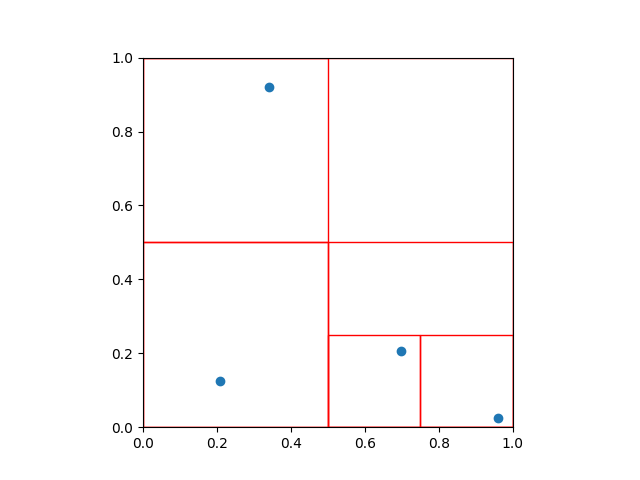

In [63]:
fig,ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

points = [source.centre for source in particles]
X,Y = np.real(points), np.imag(points)

ax.scatter(X,Y)

import matplotlib.patches as patches

def draw_rectangles(cell:Cell):
    corner = cell.centre - cell.size*(0.5+0.5j)
    p = patches.Rectangle((corner.real,corner.imag),cell.size,cell.size, fill=False, color='red')
    ax.add_patch(p)
    if cell.bit_children == 0:
        return
    else:
        for child in cell.children:
            if child:
                draw_rectangles(child)

draw_rectangles(root)

plt.show()

In [40]:
# particles = []
# particles.append(Particle(1, 0.25*(1+1j)))
# particles.append(Particle(2, 0.25*(3+1j)))
# particles.append(Particle(-2, 0.25*(1+3j)))
# particles.append(Particle(-3, 0.25*(3+3j)))

In [9]:
for cell in cells:
    cell.multipole = np.zeros(p,dtype=complex)

root._calculate_multipole()
direct = root.multipole

root.multipole = np.zeros(p, dtype=complex)

for cell in reversed(cells):
    cell.get_multipole()
M2M = root.multipole

err = (M2M - direct)/abs(direct)
print(direct)
print(M2M)
print(err)
np.sum(abs(err))

[73.6334645  +0.j         -0.11234199-13.64611859j
 -1.01799895 -6.21929403j -0.39389398 -0.33225687j]
[73.6334645  +0.j         -0.11234199-13.64611859j
 -1.01799895 -6.21929403j -0.39389398 -0.33225687j]
[ 0.00000000e+00+0.00000000e+00j -2.60337273e-16+2.60337273e-16j
 -1.05700990e-16+2.81869308e-16j  1.07723252e-16-1.18495577e-15j]


1.85905126069737e-15

In [243]:
"""Shows numpy method is equivalent to explicit"""

z0 = -1+2j
precision = 3

multipole_for = np.zeros(precision, dtype=complex)
multipole_np = np.zeros(precision, dtype=complex)

child_multipole_real = np.random.random(precision)
child_multipole_imag = np.random.random(precision)
child_multipole = child_multipole_real + 1j*child_multipole_imag
child_multipole[0] = child_multipole[0].real

multipole_for[0] += child_multipole[0]
multipole_np[0] += child_multipole[0]

for l in range(1, precision):
    bl = - child_multipole[0] * z0**l / l
    for k in range(1,l+1):
        bl += child_multipole[k] * z0**(l-k) * sp.special.binom(l-1,k-1)
    multipole_for[l] += bl

    multipole_np[l] += \
    -(child_multipole[0] * z0**l / l) \
        + np.sum(child_multipole[1:l+1] \
                    * z0**(l-np.arange(1,l+1,1)) \
                    * sp.special.binom(l-1, np.arange(0,l,1)))

    
print(multipole_for)
print(multipole_np)

[0.59307307+0.j         1.09098377-1.04759056j 1.06862753+2.73010138j]
[0.59307307+0.j         1.09098377-1.04759056j 1.06862753+2.73010138j]
